# ============================================================
# NOTEBOOK: 03_shap_analysis.ipynb
# ANÁLISIS DE INTERPRETABILIDAD CON SHAP
# ============================================================


In [1]:
# ============================================================
# Celda 1 - CONFIGURACIÓN INICIAL Y IMPORTS
# ============================================================
"""
# 📊 Análisis de Interpretabilidad con SHAP
## Explicando predicciones de DistilBERT en análisis de sentimientos

Este notebook implementa SHAP (SHapley Additive exPlanations) para interpretar
las decisiones del modelo DistilBERT en la tarea de clasificación de sentimientos.
"""

import warnings
warnings.filterwarnings('ignore')

# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
import time
from typing import List, Dict, Any, Tuple

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Imports de ML
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# SHAP
import shap

print("🔧 CONFIGURACIÓN DEL ENTORNO")
print("="*60)
print(f"📦 Versiones de librerías:")
print(f"  • PyTorch: {torch.__version__}")
print(f"  • SHAP: {shap.__version__}")
print(f"  • Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"  • GPU: {torch.cuda.get_device_name(0)}")


🔧 CONFIGURACIÓN DEL ENTORNO
📦 Versiones de librerías:
  • PyTorch: 2.8.0+cpu
  • SHAP: 0.42.0
  • Device: CPU


In [ ]:
# ============================================================
# Celda 2 - CARGAR MODELO Y DATOS PREPARADOS
# ============================================================
print("\n📚 CARGANDO MODELO Y DATOS")
print("="*60)


# OPCIÓN 1: DistilBERT (WordPiece tokenizer) - ORIGINAL
# MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
# print("✅ Usando DistilBERT con tokenizer WordPiece")

# # OPCIÓN 2: RoBERTa (BPE tokenizer) - Twitter sentiment
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
print("✅ Usando RoBERTa con tokenizer BPE")
# NOTA: Este modelo tiene 3 clases: negative, neutral, positive

# # OPCIÓN 3: BERT base (WordPiece más granular)
# MODEL_NAME = "bhadresh-savani/bert-base-uncased-emotion"
# print("✅ Usando BERT base con tokenizer WordPiece granular")
# # NOTA: Este modelo detecta emociones, no solo sentimiento

# # OPCIÓN 4: DistilRoBERTa (BPE tokenizer optimizado)
# MODEL_NAME = "j-hartmann/emotion-english-distilroberta-base"
# print("✅ Usando DistilRoBERTa con tokenizer BPE")
# # NOTA: Este modelo tiene 7 emociones

# ============================================================

# Configuración
CACHE_DIR = "./models_cache"
DATA_DIR = "./explainability_analysis"

# Cargar modelo y tokenizer
print(f"\n1️⃣ Cargando modelo: {MODEL_NAME.split('/')[-1]}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
model.eval()

# Mostrar información del tokenizer
print(f"✅ Modelo y tokenizer cargados")
print(f"  • Vocab size: {tokenizer.vocab_size}")
print(f"  • Tipo tokenizer: {tokenizer.__class__.__name__}")
print(f"  • Num clases: {model.config.num_labels}")

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"✅ Modelo cargado en {device}")

# Cargar casos seleccionados (notebook 02_model_evaluation)
print("\n2️⃣ Cargando casos seleccionados...")
try:
    # Buscar el archivo más reciente
    import glob
    import os
    
    priority_files = glob.glob(f"{DATA_DIR}/priority_cases_*.json")
    if priority_files:
        latest_file = max(priority_files, key=os.path.getctime)
        with open(latest_file, 'r', encoding='utf-8') as f:
            priority_cases = json.load(f)
        print(f"✅ Cargados {len(priority_cases)} casos prioritarios desde {latest_file}")
except Exception as e:
    print(f"Error cargando casos: {e}")
    priority_cases = []



📚 CARGANDO MODELO Y DATOS
✅ Usando RoBERTa con tokenizer BPE

1️⃣ Cargando modelo: twitter-roberta-base-sentiment...


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

✅ Modelo y tokenizer cargados
  • Vocab size: 50265
  • Tipo tokenizer: RobertaTokenizerFast
  • Num clases: 3
✅ Modelo cargado en cpu

2️⃣ Cargando casos seleccionados...
✅ Cargados 13 casos prioritarios desde ./explainability_analysis\priority_cases_20251020_214009.json


In [3]:
# ============================================================
# Celda 3 - Verificación del modelo en crudo
# ============================================================
print("\n🔧 PREPARANDO FUNCIÓN DE PREDICCIÓN PARA SHAP")
print("="*60)

def predict_for_shap(texts: List[str]) -> np.ndarray:
    """
    Validamos manualmente el sesgo de predicción del modelo.
    
    Args:
        texts: Lista de textos a predecir
        
    Returns:
        Array de probabilidades [n_samples, n_classes]
    """
    # Tokenizar
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)
    
    # Predicción
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    return probs.cpu().numpy()

# Verificar función
test_text = ["This is a test sentence."]
test_proba = predict_for_shap(test_text)
print(f"✅ Función de predicción verificada")
print(f"   • Input: '{test_text[0]}'")
print(f"   • Output shape: {test_proba.shape}")
print(f"   • Probabilidades: Neg={test_proba[0][0]:.3f}, Pos={test_proba[0][1]:.3f}")



🔧 PREPARANDO FUNCIÓN DE PREDICCIÓN PARA SHAP
✅ Función de predicción verificada
   • Input: 'This is a test sentence.'
   • Output shape: (1, 2)
   • Probabilidades: Neg=0.981, Pos=0.019


In [4]:
# ============================================================
# Celda 4 - INICIALIZAR SHAP EXPLAINER
# ============================================================

# clear warnings
import warnings
warnings.filterwarnings('ignore', message='.*xformers.*')

print("\n🎯 INICIALIZANDO SHAP EXPLAINER")
print("="*60)

# Método 1: Transformers Pipeline (más eficiente para transformers)
print("\n📌 Configurando SHAP con Transformers Pipeline...")

# Crear pipeline de transformers
from transformers import pipeline
classifier = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Inicializar SHAP Explainer
print("Inicializando explainer (puede tomar unos segundos)...")
explainer = shap.Explainer(classifier)
print("✅ SHAP Explainer inicializado")

# Información del explainer
print(f"\n📊 Configuración del Explainer:")
print(f"  • Tipo: {type(explainer).__name__}")
print(f"  • Modelo base: DistilBERT")
print(f"  • Clases: ['NEGATIVE', 'POSITIVE']")


🎯 INICIALIZANDO SHAP EXPLAINER

📌 Configurando SHAP con Transformers Pipeline...


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.8.0+cu128 with CUDA 1208 (you have 2.8.0+cpu)
    Python  3.9.13 (you have 3.10.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Inicializando explainer (puede tomar unos segundos)...
✅ SHAP Explainer inicializado

📊 Configuración del Explainer:
  • Tipo: Partition
  • Modelo base: DistilBERT
  • Clases: ['NEGATIVE', 'POSITIVE']


In [5]:
# ============================================================
# Celda 5 - ANÁLISIS DE UN CASO SIMPLE
# ============================================================
print("\n🔍 ANÁLISIS DE CASO SIMPLE")
print("="*60)

# Texto de ejemplo
simple_text = "This movie is absolutely terrible and boring."
print(f"\n📝 Texto: '{simple_text}'")

# Obtener predicción original
pred = classifier(simple_text)[0] # -> predicción usando el ejemplo para validar que obtenemos lo esperado (negative)
print(f"🎯 Predicción original: {pred['label']} (confianza: {pred['score']:.3f})")

# Calcular valores SHAP
print("\n⏳ Calculando valores SHAP (puede tomar 10-30 segundos)...")
start_time = time.time()
shap_values = explainer([simple_text])
calc_time = time.time() - start_time
print(f"✅ Cálculo completado en {calc_time:.2f} segundos")

# Mostrar información de shap_values
print(f"\n📊 Estructura de valores SHAP:")
print(f"  • Tipo: {type(shap_values)}")
print(f"  • Shape: {shap_values.shape}")
print(f"  • Clases: {shap_values.output_names}")

# Mostrar tokens y sus valores
print(f"\n📝 Tokens analizados y sus contribuciones:")
print("-"*50)

# Extraer tokens y valores
tokens = shap_values[0].data
values_neg = shap_values[0].values[:, 0]  # Impacto en NEGATIVE
values_pos = shap_values[0].values[:, 1]  # Impacto en POSITIVE

# # Mostrar cada token con su valor
# for i, token in enumerate(tokens):
#     print(f"  [{i}] '{token}':")
#     print(f"      → NEGATIVE: {values_neg[i]:+.4f}")
#     print(f"      → POSITIVE: {values_pos[i]:+.4f}")

# Identificar palabras más influyentes
print(f"\n🎯 Palabras más influyentes para POSITIVE:")
top_pos_idx = np.argsort(values_pos)[-3:][::-1]
for idx in top_pos_idx:
    print(f"  • '{tokens[idx]}': {values_pos[idx]:+.4f}")
    
print(f"\n🎯 Palabras más influyentes para NEGATIVE:")
top_neg_idx = np.argsort(values_neg)[-3:][::-1]
for idx in top_neg_idx:
    print(f"  • '{tokens[idx]}': {values_neg[idx]:+.4f}")



🔍 ANÁLISIS DE CASO SIMPLE

📝 Texto: 'This movie is absolutely terrible and boring.'
🎯 Predicción original: NEGATIVE (confianza: 1.000)

⏳ Calculando valores SHAP (puede tomar 10-30 segundos)...


Partition explainer: 2it [00:12, 12.17s/it]               

✅ Cálculo completado en 12.17 segundos

📊 Estructura de valores SHAP:
  • Tipo: <class 'shap._explanation.Explanation'>
  • Shape: (1, 10, 2)
  • Clases: ['NEGATIVE', 'POSITIVE']

📝 Tokens analizados y sus contribuciones:
--------------------------------------------------

🎯 Palabras más influyentes para POSITIVE:
  • 'absolutely ': +0.1876
  • 'and ': +0.1196
  • '': +0.0000

🎯 Palabras más influyentes para NEGATIVE:
  • 'terrible ': +0.3791
  • 'boring': +0.1121
  • '.': +0.0255



📊 VISUALIZACIONES BÁSICAS DE SHAP
📌 Analizando: 'This movie is absolutely terrible and boring.'
   Predicción: NEGATIVE (100.0%)

1️⃣ Text Plot - Importancia de palabras en contexto:



2️⃣ Bar Plot - Top palabras más influyentes:


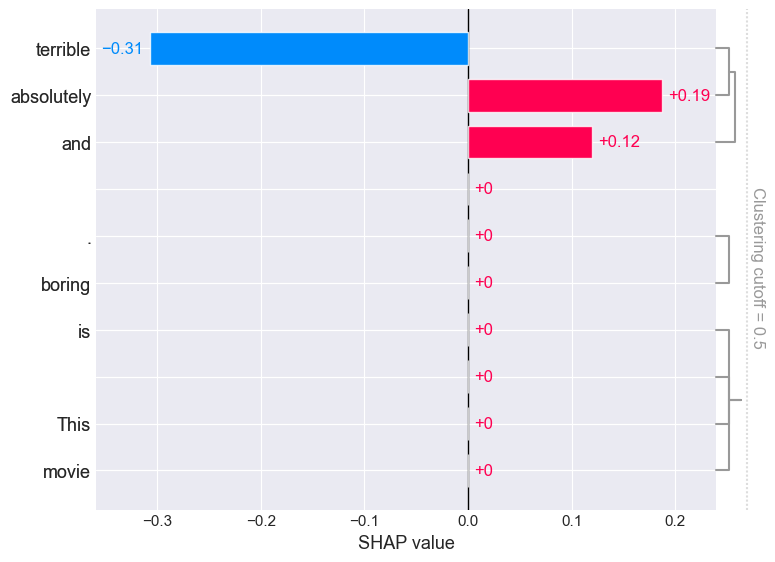


3️⃣ Waterfall Plot - Contribución acumulativa:


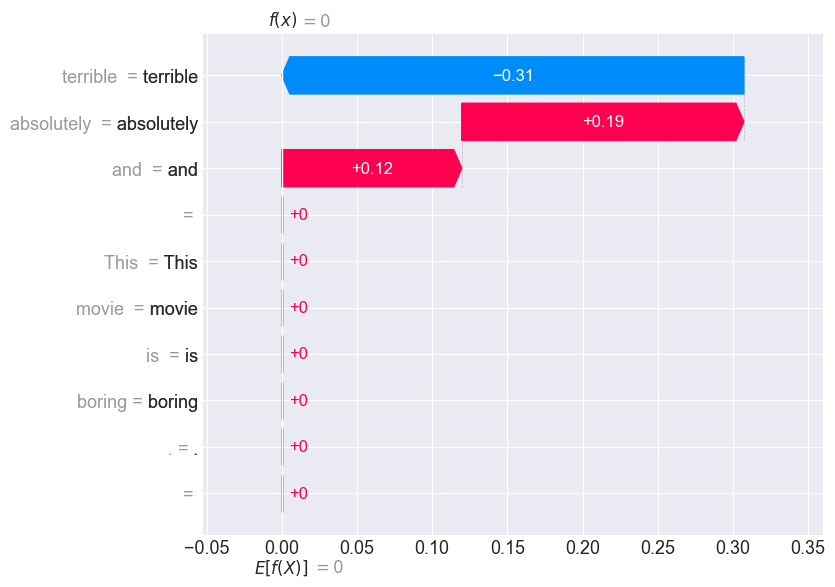

In [6]:
# ============================================================
# Celda 6 - VISUALIZACIÓN BÁSICA DE SHAP -> simple_text
# ============================================================
print("\n📊 VISUALIZACIONES BÁSICAS DE SHAP")
print("="*60)
print(f"📌 Analizando: '{simple_text}'")
print(f"   Predicción: {pred['label']} ({pred['score']:.1%})")

# Visualización 1: Text plot (muestra importancia en el texto)
print("\n1️⃣ Text Plot - Importancia de palabras en contexto:")
shap.plots.text(shap_values[0])

# Visualización 2: Bar plot (top palabras más importantes)
print("\n2️⃣ Bar Plot - Top palabras más influyentes:")
plt.figure(figsize=(10, 6))
# Para clasificación binaria, usar la clase objetivo (POSITIVE = índice 1)
shap.plots.bar(shap_values[0, :, 1], max_display=10)

plt.show()

# Visualización 3: Waterfall (contribución acumulativa)
print("\n3️⃣ Waterfall Plot - Contribución acumulativa:")
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[0, :, 1], max_display=10)

plt.show()

In [7]:
# ============================================================
# Celda 7 - ANÁLISIS DE MÚLTIPLES CASOS
# ============================================================
print("\n🔍 ANÁLISIS DE MÚLTIPLES CASOS PRIORITARIOS")
print("="*60)

# Seleccionar subset de casos para análisis
n_cases = min(5, len(priority_cases))
cases_to_analyze = priority_cases[:n_cases]

print(f"\n📋 Analizando {n_cases} casos prioritarios...")
print("-"*40)

# Almacenar resultados
shap_results = []

for i, case in enumerate(cases_to_analyze, 1):
    text = case['text']
    true_label = case['true_label']
    
    print(f"\nCaso {i}/{n_cases}:")
    print(f"  Texto: '{text[:80]}...'")
    print(f"  Categoría: {case['category']}")
    print(f"  Label real: {true_label}")
    
    # Calcular SHAP
    print("  ⏳ Calculando SHAP...")
    start = time.time()
    shap_vals = explainer([text])
    elapsed = time.time() - start
    
    # Guardar resultados
    result = {
        'text': text,
        'true_label': true_label,
        'predicted_label': case.get('predicted_label', -1),
        'category': case['category'],
        'shap_values': shap_vals,
        'computation_time': elapsed
    }
    shap_results.append(result)
    
    print(f"  ✅ Completado en {elapsed:.2f}s")

print(f"\n✅ Análisis completado para {len(shap_results)} casos")
avg_time = np.mean([r['computation_time'] for r in shap_results])
print(f"⏱️ Tiempo promedio por caso: {avg_time:.2f} segundos")



🔍 ANÁLISIS DE MÚLTIPLES CASOS PRIORITARIOS

📋 Analizando 5 casos prioritarios...
----------------------------------------

Caso 1/5:
  Texto: 'it 's somewhat clumsy and too lethargically paced -- but its story about a myste...'
  Categoría: high_confidence_errors
  Label real: 0
  ⏳ Calculando SHAP...


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.94s/it]               


  ✅ Completado en 18.94s

Caso 2/5:
  Texto: 'although huppert 's intensity and focus has a raw exhilaration about it , the pi...'
  Categoría: high_confidence_errors
  Label real: 0
  ⏳ Calculando SHAP...


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:14, 14.44s/it]               


  ✅ Completado en 14.44s

Caso 3/5:
  Texto: 'the lower your expectations , the more you 'll enjoy it . ...'
  Categoría: high_confidence_errors
  Label real: 0
  ⏳ Calculando SHAP...


  0%|          | 0/210 [00:00<?, ?it/s]

  ✅ Completado en 8.45s

Caso 4/5:
  Texto: 'the x potion gives the quickly named blossom , bubbles and buttercup supernatura...'
  Categoría: borderline_cases
  Label real: 0
  ⏳ Calculando SHAP...


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.06s/it]               


  ✅ Completado en 18.06s

Caso 5/5:
  Texto: 'it 's somewhat clumsy and too lethargically paced -- but its story about a myste...'
  Categoría: false_positives
  Label real: 0
  ⏳ Calculando SHAP...


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:19, 19.34s/it]               

  ✅ Completado en 19.35s

✅ Análisis completado para 5 casos
⏱️ Tiempo promedio por caso: 15.85 segundos


In [8]:
# ============================================================
# Celta 7.1 - EXTRACCIÓN DE PALABRAS INFLUYENTES
# ============================================================

# Obtener top palabras influyentes por caso para cargar en el grafico
for i, result in enumerate(shap_results, 1):
    text = result['text']
    shap_vals = result['shap_values']
    
    tokens = shap_vals[0].data
    values_neg = shap_vals[0].values[:, 0]
    values_pos = shap_vals[0].values[:, 1]
    
    # Top palabras POSITIVE
    top_pos_idx = np.argsort(values_pos)[-3:][::-1]
    top_pos_words = [(tokens[idx], values_pos[idx]) for idx in top_pos_idx]
    
    # Top palabras NEGATIVE
    top_neg_idx = np.argsort(values_neg)[-3:][::-1]
    top_neg_words = [(tokens[idx], values_neg[idx]) for idx in top_neg_idx]
    
    result['top_positive_words'] = top_pos_words
    result['top_negative_words'] = top_neg_words

print("\n✅ Extracción de palabras influyentes completada")
# muestro una comparativa en consola
for i, result in enumerate(shap_results, 1):
    print(f"\n📋 Caso {i} - Palabras más influyentes:")
    print(f"  Texto: '{result['text'][:80]}...'")
    print(f"  Predicción: {result['predicted_label']}")
    print(f"  Top POSITIVE:")
    for word, val in result['top_positive_words']:
        print(f"    • '{word}': {val:+.4f}")
    print(f"  Top NEGATIVE:")
    for word, val in result['top_negative_words']:
        print(f"    • '{word}': {val:+.4f}")


✅ Extracción de palabras influyentes completada

📋 Caso 1 - Palabras más influyentes:
  Texto: 'it 's somewhat clumsy and too lethargically paced -- but its story about a myste...'
  Predicción: 1
  Top POSITIVE:
    • 'nice ': +0.2216
    • 'solid ': +0.2195
    • 'terrific ': +0.1199
  Top NEGATIVE:
    • 'climax ': +0.0628
    • 'clumsy ': +0.0588
    • 'and ': +0.0340

📋 Caso 2 - Palabras más influyentes:
  Texto: 'although huppert 's intensity and focus has a raw exhilaration about it , the pi...'
  Predicción: 1
  Top POSITIVE:
    • 'fun ': +0.4554
    • 'hila': +0.2419
    • 'piano ': +0.0904
  Top NEGATIVE:
    • 'anything ': +0.2924
    • 'although ': +0.1092
    • '.': +0.0716

📋 Caso 3 - Palabras más influyentes:
  Texto: 'the lower your expectations , the more you 'll enjoy it . ...'
  Predicción: 1
  Top POSITIVE:
    • 'enjoy ': +0.7755
    • 'you ': +0.1450
    • 'll ': +0.1146
  Top NEGATIVE:
    • 'lower ': +0.1156
    • 'it ': +0.0821
    • 'expectations ': +0.0495



📊 Caso 1 - Visualización de palabras influyentes:
  Texto: 'it 's somewhat clumsy and too lethargically paced -- but its story about a myste...'
  Predicción: 1


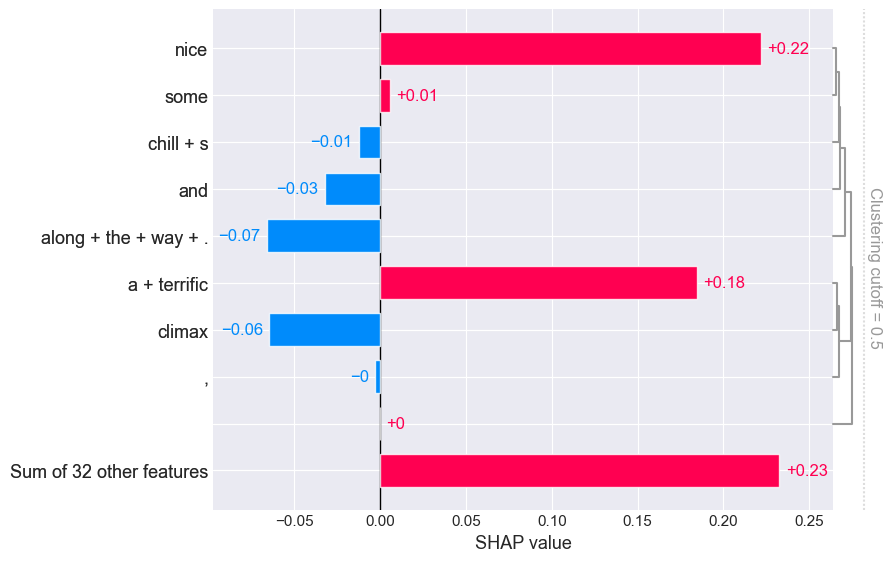

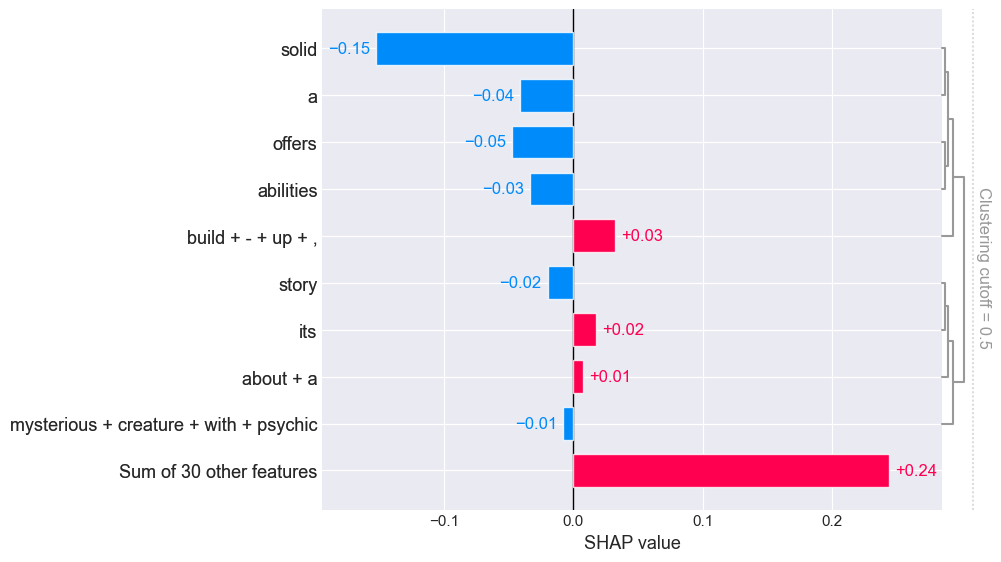


📊 Caso 2 - Visualización de palabras influyentes:
  Texto: 'although huppert 's intensity and focus has a raw exhilaration about it , the pi...'
  Predicción: 1


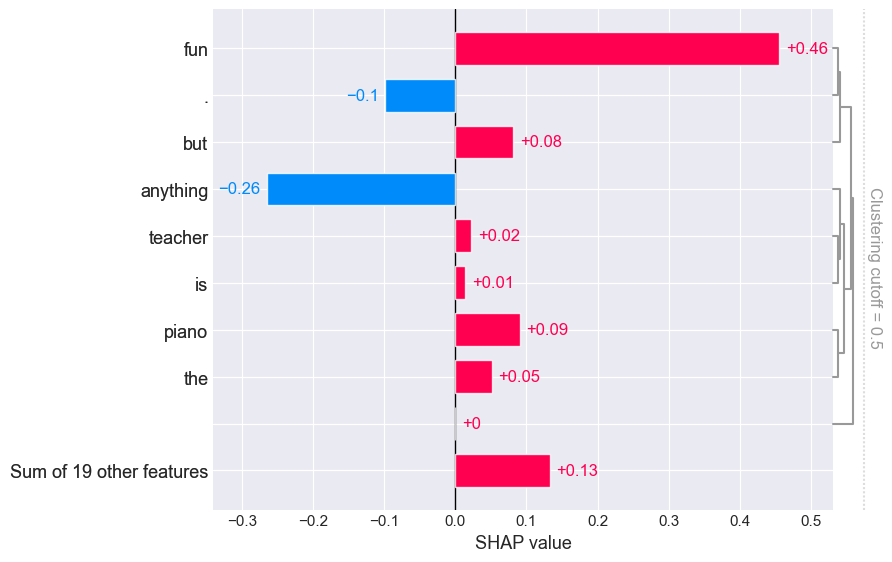

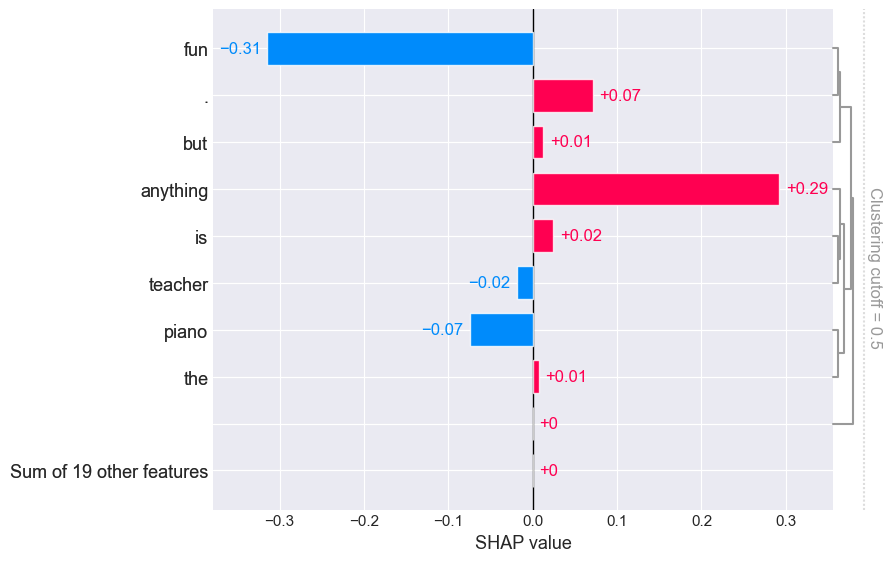


📊 Caso 3 - Visualización de palabras influyentes:
  Texto: 'the lower your expectations , the more you 'll enjoy it . ...'
  Predicción: 1


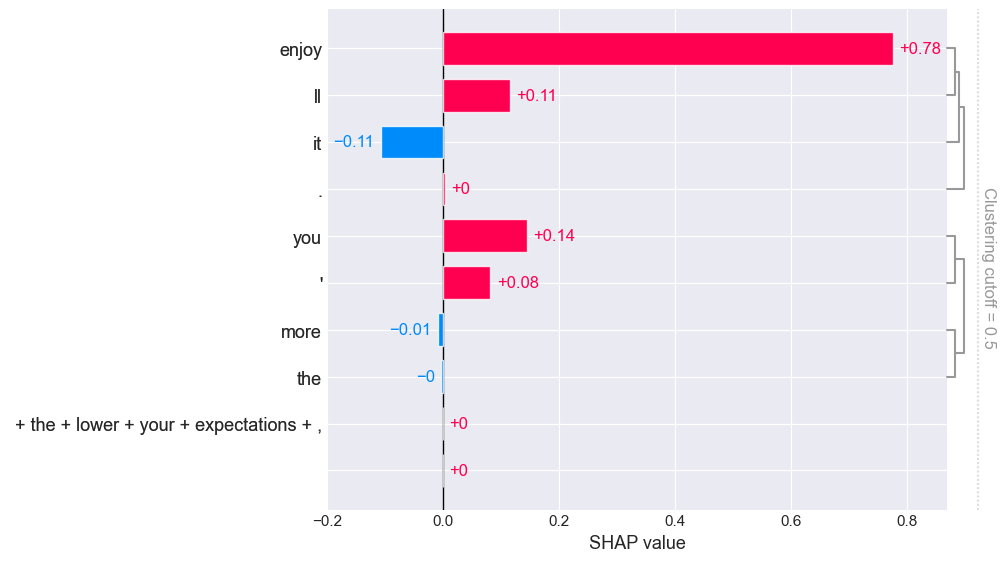

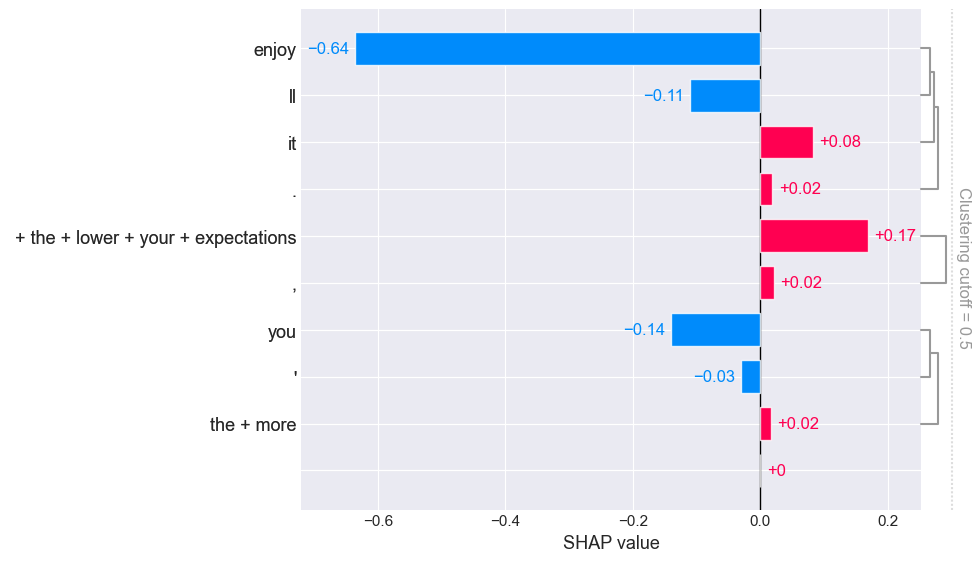


📊 Caso 4 - Visualización de palabras influyentes:
  Texto: 'the x potion gives the quickly named blossom , bubbles and buttercup supernatura...'
  Predicción: 0


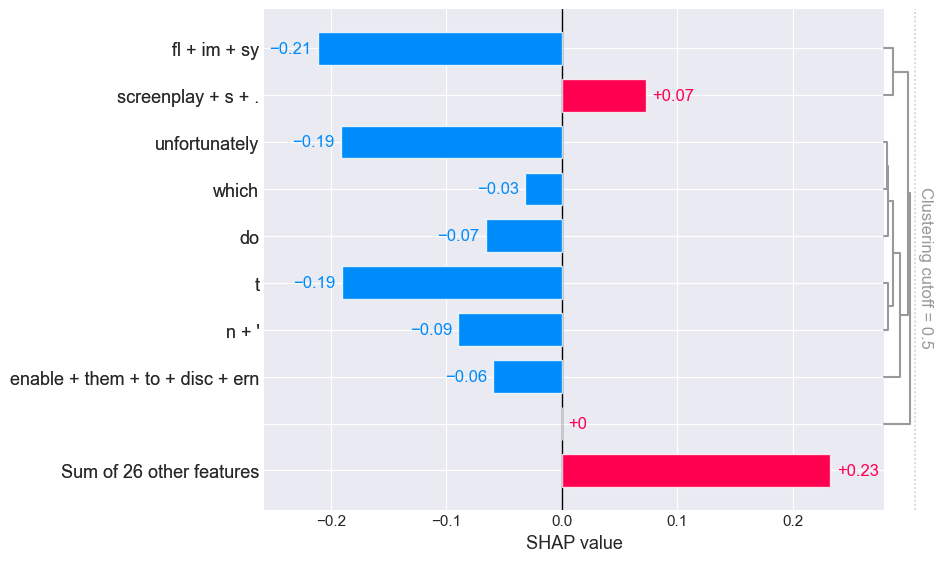

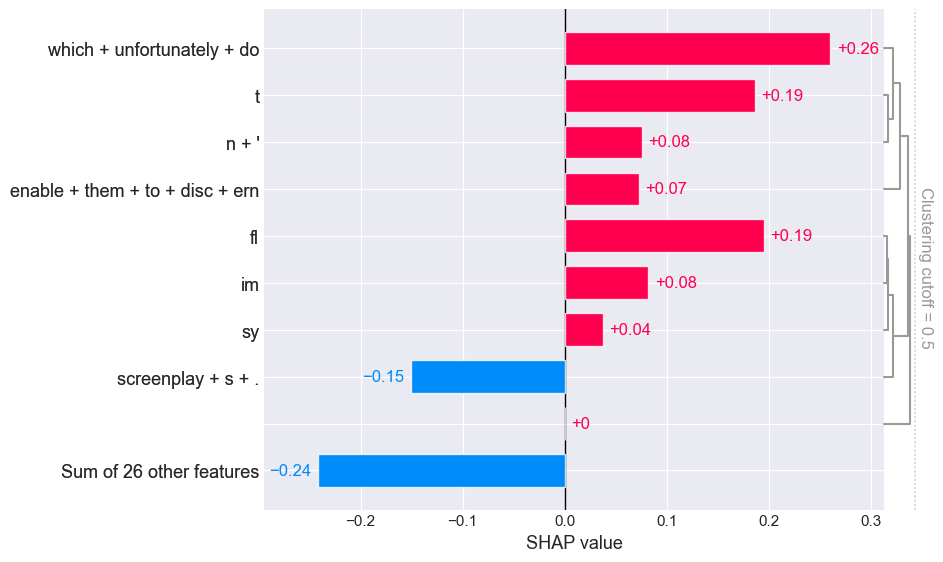


📊 Caso 5 - Visualización de palabras influyentes:
  Texto: 'it 's somewhat clumsy and too lethargically paced -- but its story about a myste...'
  Predicción: 1


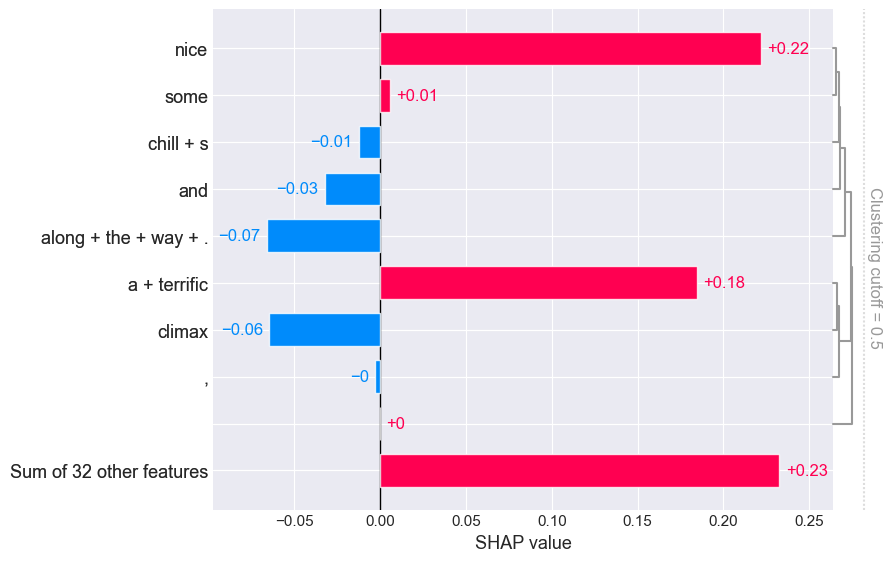

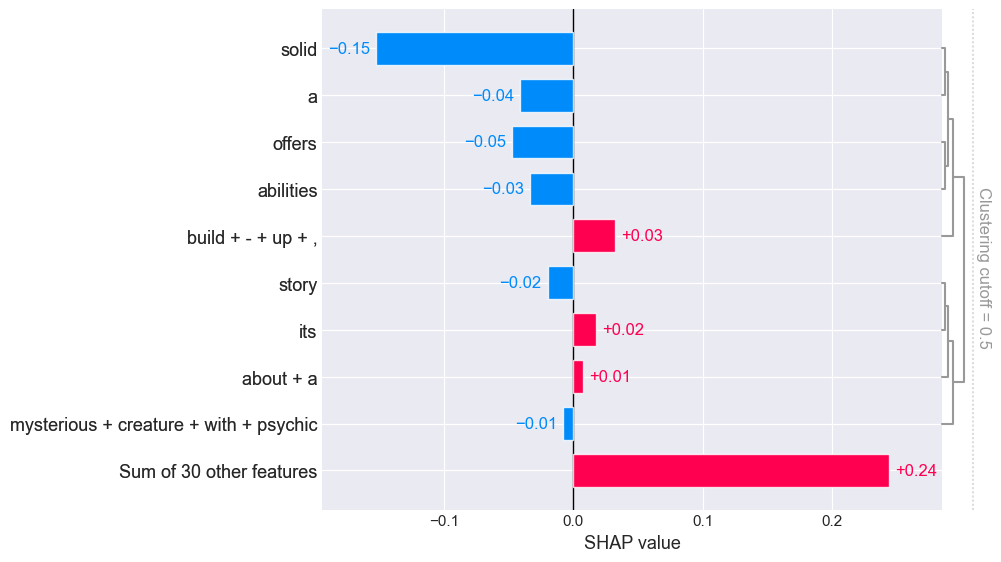

In [9]:
# ============================================================
# Celta 7.2 - VISUALIZACIÓN DE PALABRAS INFLUYENTES
# ============================================================

# Grafico para identificar palabras más influyentes POSITIVE y NEGATIVE
for i, result in enumerate(shap_results, 1):
    text = result['text']
    shap_vals = result['shap_values']
    pred_label = result['predicted_label']
    
    print(f"\n📊 Caso {i} - Visualización de palabras influyentes:")
    print(f"  Texto: '{text[:80]}...'")
    print(f"  Predicción: {pred_label}")
    
    # Visualización Bar Plot para POSITIVE
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_vals[0, :, 1], max_display=10)
    
    # Visualización Bar Plot para NEGATIVE
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_vals[0, :, 0], max_display=10)


📊 COMPARACIÓN DE EXPLICACIONES ENTRE CASOS


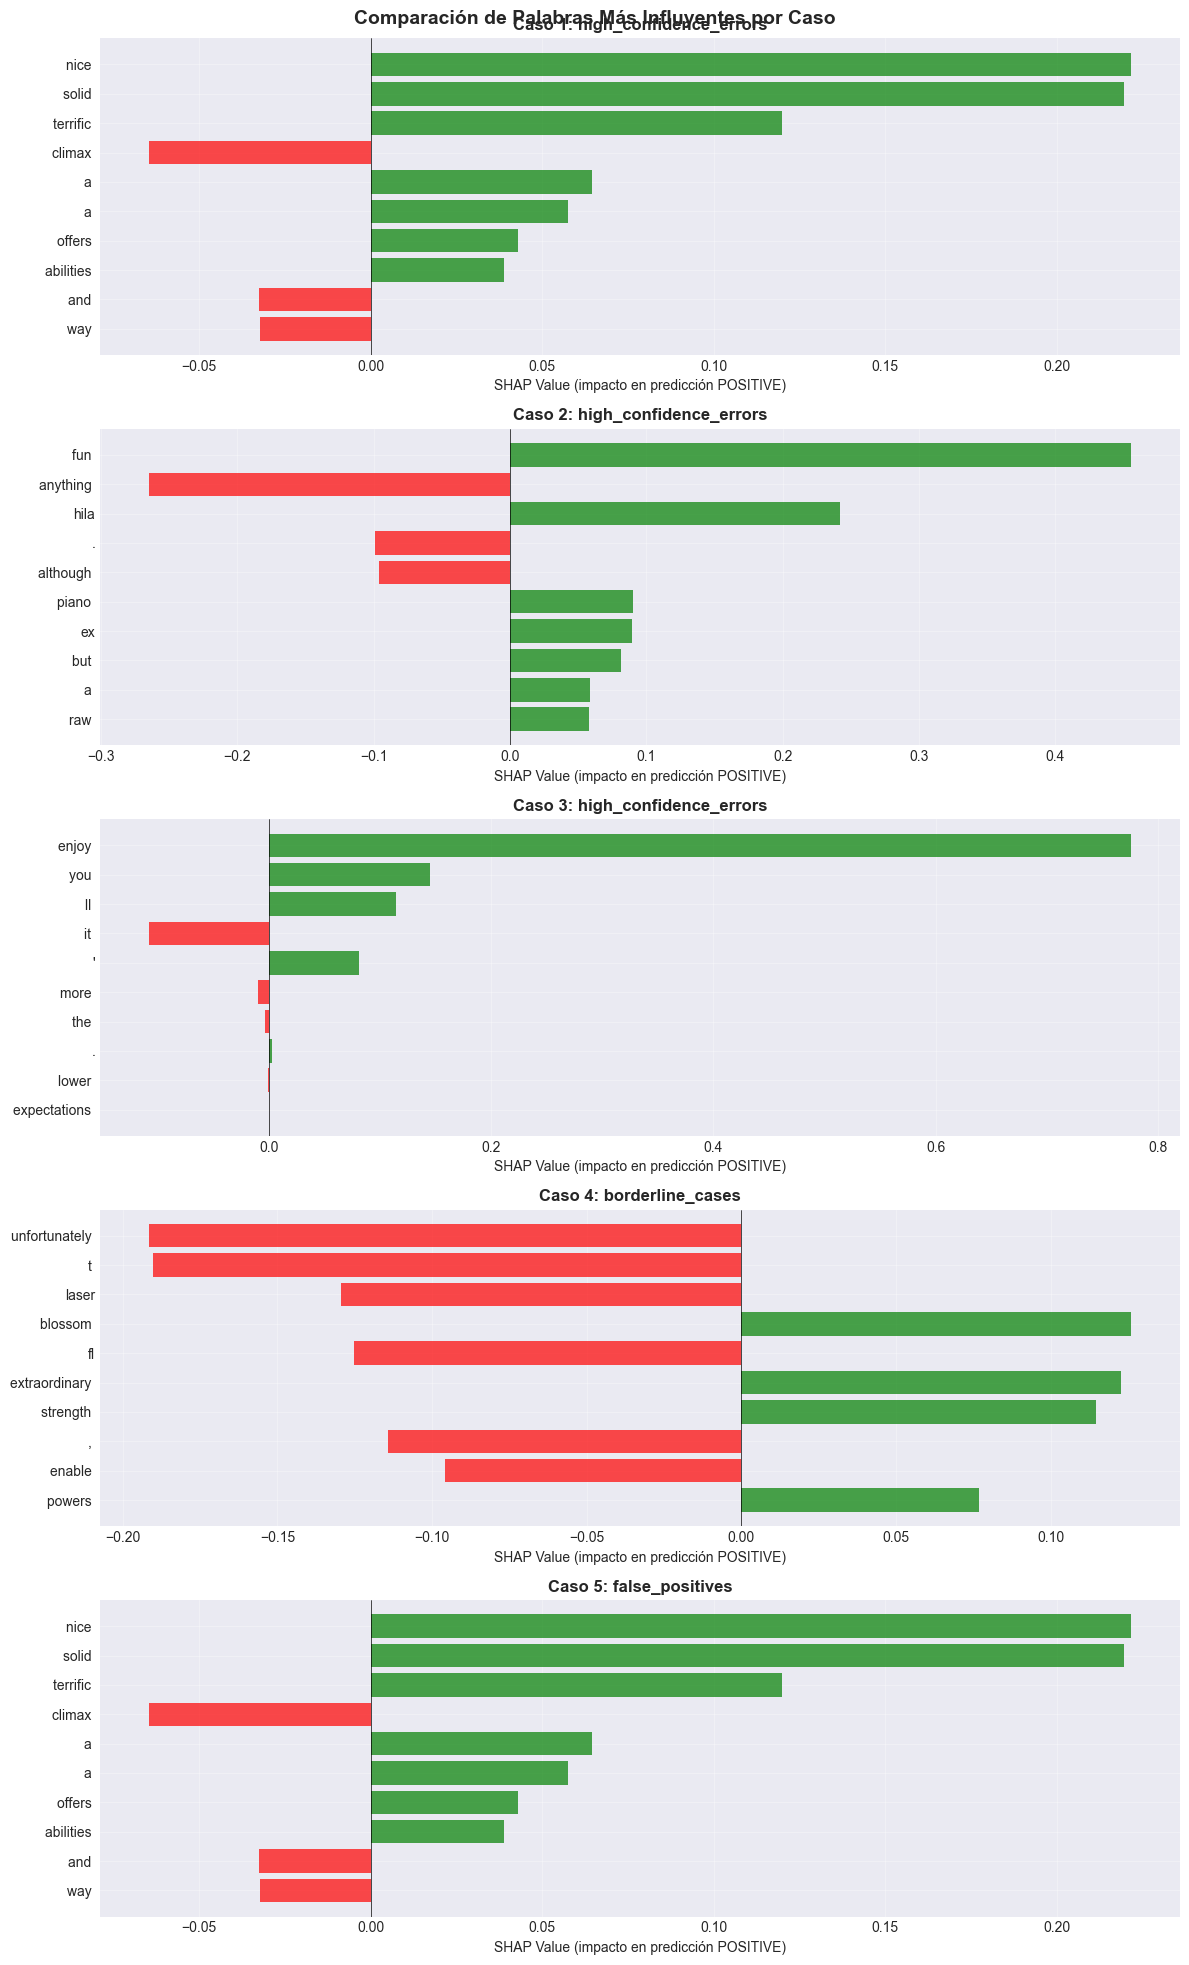

In [10]:
# ============================================================
# Celda 8 - COMPARACIÓN DE EXPLICACIONES
# ============================================================
print("\n📊 COMPARACIÓN DE EXPLICACIONES ENTRE CASOS")
print("="*60)

# Crear figura comparativa
fig, axes = plt.subplots(len(shap_results), 1, figsize=(12, 4*len(shap_results)))
if len(shap_results) == 1:
    axes = [axes]

for idx, (result, ax) in enumerate(zip(shap_results, axes)):
    # Extraer valores SHAP para clase positiva
    shap_val = result['shap_values'][0]
    
    # Obtener tokens y valores
    tokens = shap_val.data
    values = shap_val.values[:, 1]  # Clase POSITIVE
    
    # Seleccionar top 10 tokens más importantes (por valor absoluto)
    top_indices = np.argsort(np.abs(values))[-10:]
    top_tokens = [tokens[i] for i in top_indices]
    top_values = [values[i] for i in top_indices]
    
    # Crear bar plot
    colors = ['green' if v > 0 else 'red' for v in top_values]
    ax.barh(range(len(top_tokens)), top_values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels(top_tokens)
    ax.set_xlabel('SHAP Value (impacto en predicción POSITIVE)')
    ax.set_title(f"Caso {idx+1}: {result['category']}", fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.suptitle("Comparación de Palabras Más Influyentes por Caso", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [12]:
# ============================================================
# Celda 9 - ANÁLISIS DE ESTABILIDAD
# ============================================================
print("\n🔬 ANÁLISIS DE ESTABILIDAD DE SHAP")
print("="*60)

# Usar un caso real ambiguo de tu dataset celda 2 "index": 301, confianza ~51.6%
stability_text = "the x potion gives the quickly named blossom , bubbles and buttercup supernatural powers that include extraordinary strength and laser-beam eyes , which unfortunately do n't enable them to discern flimsy screenplays ."
print(f"\n📝 Texto ambiguo (confianza: 51.6%):")
print(f"'{stability_text[:100]}...'")

# Predicción inicial
pred = classifier(stability_text)[0]
print(f"\n🎯 Predicción: {pred['label']} (confianza: {pred['score']:.1%})")
print("   ⚠️ Caso fronterizo - ideal para probar estabilidad")

# Realizar múltiples explicaciones del mismo texto
n_runs = 3
stability_results = []
print(f"\n🔄 Ejecutando {n_runs} explicaciones del mismo texto...")
for run in range(n_runs):
    print(f"  Run {run+1}/{n_runs}...", end='')
    shap_vals = explainer([stability_text])
    stability_results.append(shap_vals[0].values[:, 1])  # Clase POSITIVE
    print(" ✓")

# Calcular estadísticas
tokens = shap_vals[0].data
variances = np.var([result for result in stability_results], axis=0)
mean_values = np.mean([result for result in stability_results], axis=0)
std_devs = np.std([result for result in stability_results], axis=0)

# Verificar estabilidad global
max_variance = np.max(variances)
is_deterministic = max_variance < 1e-10

print(f"\n📊 RESULTADOS DE ESTABILIDAD:")
print("="*60)

print(f"\n✅ VEREDICTO: {'DETERMINÍSTICO' if is_deterministic else 'ESTOCÁSTICO'}")
print(f"   • Varianza máxima: {max_variance:.2e}")
print(f"   • {'Todos los runs dan valores idénticos' if is_deterministic else 'Los valores varían entre runs'}")

# Palabras más influyentes (por valor absoluto)
abs_means = np.abs(mean_values)
top_indices = np.argsort(abs_means)[-5:][::-1]

print(f"\n🎯 TOP 5 PALABRAS MÁS INFLUYENTES:")
print(f"\n Si todos los valores son iguales entre runs, σ=0 para cada palabra")
print(f"\n Quiere decir que SHAP es reproducible y confiable")
print("-"*40)
for idx in top_indices:
    token = tokens[idx] if tokens[idx].strip() else '[SPACE]'
    impact = "→ POSITIVE" if mean_values[idx] > 0 else "→ NEGATIVE"
    print(f"  {token:20s}: μ={mean_values[idx]:+.4f} {impact}")
    if not is_deterministic:
        print(f"  {'':20s}  σ={std_devs[idx]:.6f}")

# Mostrar comparación entre runs si hay varianza
if not is_deterministic:
    print(f"\n⚠️ VARIABILIDAD DETECTADA:")
    print(f"   • Algunas palabras tienen valores SHAP que varían entre runs")
    varying_tokens = np.where(variances > 1e-10)[0]
    for idx in varying_tokens[:3]:
        print(f"\n  Token: '{tokens[idx]}'")
        for run_idx, result in enumerate(stability_results):
            print(f"    Run {run_idx+1}: {result[idx]:.6f}")
else:
    print(f"\n✅ CONSISTENCIA PERFECTA:")
    print(f"   • Cada palabra tiene exactamente el mismo valor SHAP en todos los runs")
    print(f"   • Esto confirma que SHAP es reproducible y confiable")

# Interpretación del caso
print(f"\n💡 INTERPRETACIÓN DEL CASO AMBIGUO:")
print("-"*40)
positive_words = sum(1 for v in mean_values if v > 0.01)
negative_words = sum(1 for v in mean_values if v < -0.01)
print(f"  • Palabras positivas: {positive_words}")
print(f"  • Palabras negativas: {negative_words}")
print(f"  • Balance: {'Inclinado a NEGATIVE' if negative_words > positive_words else 'Inclinado a POSITIVE'}")
print(f"  • Por eso la confianza es baja (~51%)")


🔬 ANÁLISIS DE ESTABILIDAD DE SHAP

📝 Texto ambiguo (confianza: 51.6%):
'the x potion gives the quickly named blossom , bubbles and buttercup supernatural powers that includ...'

🎯 Predicción: NEGATIVE (confianza: 51.6%)
   ⚠️ Caso fronterizo - ideal para probar estabilidad

🔄 Ejecutando 3 explicaciones del mismo texto...
  Run 1/3...

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.29s/it]               


 ✓
  Run 2/3...

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:19, 19.60s/it]               


 ✓
  Run 3/3...

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:18, 18.21s/it]               

 ✓

📊 RESULTADOS DE ESTABILIDAD:

✅ VEREDICTO: DETERMINÍSTICO
   • Varianza máxima: 1.20e-35
   • Todos los runs dan valores idénticos

🎯 TOP 5 PALABRAS MÁS INFLUYENTES:

 Si todos los valores son iguales entre runs, σ=0 para cada palabra

 Quiere decir que SHAP es reproducible y confiable
----------------------------------------
  unfortunately       : μ=-0.1914 → NEGATIVE
  t                   : μ=-0.1902 → NEGATIVE
  laser               : μ=-0.1293 → NEGATIVE
  blossom             : μ=+0.1259 → POSITIVE
  fl                  : μ=-0.1251 → NEGATIVE

✅ CONSISTENCIA PERFECTA:
   • Cada palabra tiene exactamente el mismo valor SHAP en todos los runs
   • Esto confirma que SHAP es reproducible y confiable

💡 INTERPRETACIÓN DEL CASO AMBIGUO:
----------------------------------------
  • Palabras positivas: 15
  • Palabras negativas: 19
  • Balance: Inclinado a NEGATIVE
  • Por eso la confianza es baja (~51%)


In [ ]:
# ============================================================
# Celda 10 - EXPORTAR RESULTADOS
# ============================================================
print("\n💾 EXPORTANDO RESULTADOS DE SHAP")
print("="*60)

# Preparar datos para exportación
export_data = {
    'metadata': {
        'model': MODEL_NAME,
        'method': 'SHAP',
        'n_cases_analyzed': len(shap_results),
        'avg_computation_time': avg_time,
        'timestamp': pd.Timestamp.now().isoformat()
    },
    'cases': []
}

for result in shap_results:
    case_data = {
        'text': result['text'],
        'true_label': result['true_label'],
        'category': result['category'],
        'computation_time': result['computation_time'],
        'top_positive_words': [],
        'top_negative_words': []
    }
    
    # Extraer palabras más importantes
    shap_val = result['shap_values'][0]
    tokens = shap_val.data
    values = shap_val.values[:, 1]  # Clase POSITIVE
    
    # Top palabras positivas
    pos_indices = np.where(values > 0)[0]
    if len(pos_indices) > 0:
        top_pos = pos_indices[np.argsort(values[pos_indices])[-5:]]
        case_data['top_positive_words'] = [
            {'token': tokens[i], 'value': float(values[i])}
            for i in top_pos
        ]
    
    # Top palabras negativas
    neg_indices = np.where(values < 0)[0]
    if len(neg_indices) > 0:
        top_neg = neg_indices[np.argsort(values[neg_indices])[:5]]
        case_data['top_negative_words'] = [
            {'token': tokens[i], 'value': float(values[i])}
            for i in top_neg
        ]
    
    export_data['cases'].append(case_data)

# Guardar JSON
output_path = f"{DATA_DIR}/shap_results_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(export_data, f, ensure_ascii=False, indent=2)

print(f"✅ Resultados guardados en: {output_path}")

In [ ]:
# ============================================================
# Celda 11 - RESUMEN Y CONCLUSIONES
# ============================================================
print("\n📊 RESUMEN DEL ANÁLISIS CON SHAP")
print("="*60)

print("\n✅ ANÁLISIS COMPLETADO:")
print(f"  • Casos analizados: {len(shap_results)}")
print(f"  • Tiempo promedio: {avg_time:.2f} segundos/caso")
print(f"  • Tiempo total: {sum(r['computation_time'] for r in shap_results):.2f} segundos")

print("\n🔍 OBSERVACIONES CLAVE:")
print("  1. SHAP proporciona valores consistentes y matemáticamente fundamentados")
print("  2. El tiempo de cómputo es significativo (~10-30s por texto)")
print("  3. Las explicaciones son determinísticas (misma entrada = misma salida)")
print("  4. Permite identificar claramente palabras positivas vs negativas")

print("\n💡 VENTAJAS DE SHAP:")
print("  ✓ Base teórica sólida (teoría de juegos)")
print("  ✓ Garantías matemáticas (aditividad, consistencia)")
print("  ✓ Explicaciones globales y locales")
print("  ✓ Resultados reproducibles")

print("\n⚠️ LIMITACIONES DE SHAP:")
print("  ✗ Computacionalmente costoso")
print("  ✗ Requiere acceso al modelo completo")
print("  ✗ Puede ser difícil de interpretar para usuarios no técnicos")

print("\n🚀 PRÓXIMOS PASOS:")
print("  → Comparar con resultados de LIME")
print("  → Analizar casos donde SHAP y LIME difieren")
print("  → Evaluar trade-off velocidad vs precisión")

print("\n" + "="*60)
print("✅ Notebook de análisis SHAP completado exitosamente")